# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Default inputs

In [2]:
DATE = "2020-08-24"
FORWARD = True
DAYS = 60
N = 1000
FIPS = 17031
GAMMA = 1 / 7

In [3]:
start = pd.to_datetime(DATE)

In [4]:
shift = pd.Timedelta(pd.offsets.Day(DAYS))

In [5]:
stop = start + shift if FORWARD else start - shift

In [6]:
if stop < start and not FORWARD:
    stop, start = start, stop

# Injected inputs

In [7]:
# Parameters
FIPS = 36061

# Constants

In [8]:
TODAY = pd.Timestamp.today().date()
OUTPUT_FILE_NAME = f"{TODAY}_{FIPS}_betas.csv"

# Read in USA FACTS data

In [9]:
case_df = pd.read_csv(
    "https://usafactsstatic.blob.core.windows.net/"
    "public/data/covid-19/covid_confirmed_usafacts.csv",
)

case_df = case_df[case_df["countyFIPS"] == FIPS].melt(
    # Melt dataframe (wide to long format)
    id_vars=["countyFIPS", "County Name", "State", "StateFIPS"],
    value_name="confirmed",
    var_name="date",
).astype({"date": "datetime64"})

In [10]:
# Create a day variable from the date variable
case_df = case_df.assign(
    days=(case_df["date"] - case_df["date"].min()).dt.days
)

# Trim up to but not including day 30
case_df = case_df[case_df["days"].ge(30)]

# Reverse order (highest to lowest day)
case_df = case_df.sort_values("days", ascending=False)

# Replace incorrect values with missing values
while case_df["confirmed"].pct_change().gt(0).any():
    case_df.loc[
        case_df["confirmed"].pct_change().gt(0),
        "confirmed",
    ] = np.nan

# Replace missing values with previous values
case_df.assign(
    confirmed=case_df["confirmed"].ffill()
)

# Restore the original order (lowest to highest day)
case_df = case_df.sort_values(["countyFIPS", "days"])

case_df = case_df.assign(
    # Calculate new cases from confirmed cases
    new_cases=case_df["confirmed"]
    .diff()
    .fillna(0)
)

# Read in county population data

In [11]:
cens_df = pd.read_csv(
    "https://www2.census.gov/programs-surveys/popest/datasets/"
    "2010-2019/counties/totals/co-est2019-alldata.csv",
    usecols=[
        "STATE",
        "COUNTY",
        "STNAME",
        "CTYNAME",
        "POPESTIMATE2019"
    ],
    encoding="latin-1"
)

# Combine state and county fips
cens_df = cens_df.assign(
    county_fips=(
        cens_df["STATE"].astype(str)
        + cens_df["COUNTY"].astype(str).str.zfill(3)
    ).astype(int)
)

In [12]:
# pop_df = pd.read_csv(
#     "https://usafactsstatic.blob.core.windows.net/"
#     "public/data/covid-19/covid_county_population_usafacts.csv",
#     ).set_index("countyFIPS").drop(
#         # Remove unallocated cases (FIPS 0)
#         0
#     ).reset_index()
# pop_df.head()

# Add population to case data

In [13]:
df = case_df.assign(
    population=float(
        cens_df.loc[
        cens_df["county_fips"] == FIPS,
        "POPESTIMATE2019"
        ]
    )
).set_index("date")

# Calculate growth_rate, doubling time, beta, and Rt

$\Huge r = \frac{new\_cases_t - new\_cases_{t-1}}{new\_cases_{t-1}}$

$\Huge T_d=\frac{ln(2)}{ln(r+1)}$

$\Huge \beta=\frac{r+\gamma}{N}$

$\Huge R_t=e^{r\cdot T_c}=\frac{\beta \cdot N}{\gamma}=\frac{r + \gamma}{\gamma}$

$\Huge T_c=\frac{ln(\frac{\beta \cdot N}{\gamma})}{r}=\frac{ln(\frac{r + \gamma}{\gamma})}{r}$

In [14]:
# %% Growth rate
df = df.assign(
    susceptible=df["population"] - (df["confirmed"] * 10),
    gr=df["new_cases"].pct_change() / df["days"].diff(),
)

# Remove infinite and missing growth rates 
df["gr"] = df["gr"].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["gr"])

df = df.assign(
    beta=(df["gr"] + GAMMA) / df["susceptible"],
    # Calculate 7-day moving average of growth rate
    smooth_gr=df["gr"].rolling(
        window=7,
        min_periods=1
    ).mean(),
)

df = df.assign(
    smooth_beta=(df["smooth_gr"] + GAMMA) / df["susceptible"],
)

/Users/martinskarzynski/miniconda/envs/py/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/martinskarzynski/miniconda/envs/py/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Filter out smoothed betas that are zero

In [15]:
df = df[df["smooth_beta"] != 0]

# Create beta dataframe

In [16]:
df[["days", "smooth_beta"]]

,days,smooth_beta
date,,
2020-03-03,41,-5.262755e-07
2020-03-06,44,-3.727854e-07
2020-03-07,45,3.947236e-07
2020-03-08,46,1.644682e-07
2020-03-10,48,2.719357e-07
...,...,...
2020-12-12,325,1.690423e-07
2020-12-13,326,1.461559e-07
2020-12-14,327,1.639231e-07


In [17]:
ffit3 = np.polynomial.Polynomial.fit(df.days, df.smooth_beta, deg=3)
ffit4 = np.polynomial.Polynomial.fit(df.days, df.smooth_beta, deg=4)
ffit5 = np.polynomial.Polynomial.fit(df.days, df.smooth_beta, deg=5)
ffit6 = np.polynomial.Polynomial.fit(df.days, df.smooth_beta, deg=6)

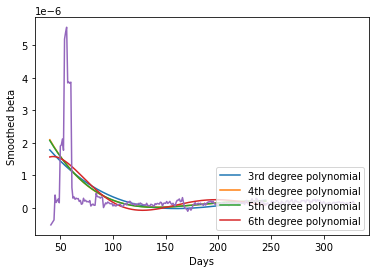

In [18]:
r = np.arange(40, 246)
plt.plot(r, ffit3(r), label="3rd degree polynomial")
plt.plot(r, ffit4(r), label="4th degree polynomial")
plt.plot(r, ffit5(r), label="5th degree polynomial")
plt.plot(r, ffit6(r), label="6th degree polynomial")
plt.plot(df.days, df.smooth_beta)
plt.ylabel("Smoothed beta")
plt.xlabel("Days")
plt.legend(loc=4)
plt.savefig(f"{TODAY}_{FIPS}_beta-polynomials.png");

In [19]:
df.days.max()

329

In [20]:
start_day = df.loc[start, "days"]
stop_day = df.loc[stop, "days"]

In [21]:
start - stop

Timedelta('-60 days +00:00:00')

In [22]:
r = np.linspace(start_day, stop_day, N)

In [23]:
r.shape

(1000,)

In [24]:
poly_betas = np.concatenate([ffit3(r), ffit4(r), ffit5(r), ffit6(r)]) 

In [25]:
poly_betas

array([1.23524057e-07, 1.23766311e-07, 1.24008574e-07, ...,
       1.19022321e-07, 1.19338289e-07, 1.19655180e-07])

In [26]:
poly_betas.shape

(4000,)

In [27]:
r4 = np.concatenate([r]*4)

In [28]:
r4.shape

(4000,)

In [29]:
beta_df = pd.DataFrame({"beta": poly_betas, "beta_day": r4})

In [30]:
beta_df.sort_values(by="beta_day")

,beta,beta_day
0,1.235241e-07,215.00000
1000,1.836783e-07,215.00000
3000,2.173008e-07,215.00000
2000,1.895223e-07,215.00000
3001,2.170849e-07,215.06006
...,...,...
998,2.765958e-07,274.93994
1999,1.676279e-07,275.00000
999,2.765664e-07,275.00000
2999,1.637998e-07,275.00000


# Statistical testing
- 2 distributions: Before and after memorial day
- compare with parametric (t-test) and non-parametric test (Mann Whitney)
- are both are normal (Shapiro-Wilk test)

# Plot betas

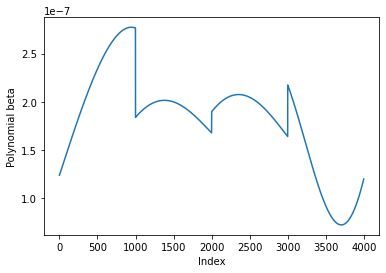

In [31]:
plt.plot(poly_betas)
plt.ylabel("Polynomial beta")
plt.xlabel("Index")
plt.savefig(f"{TODAY}_{FIPS}_beta-vs-index.png");

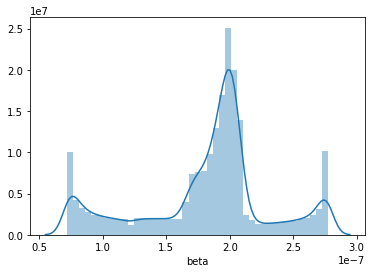

In [32]:
sns.distplot(beta_df["beta"])
plt.savefig(f"{TODAY}_{FIPS}_beta-histogram.png");

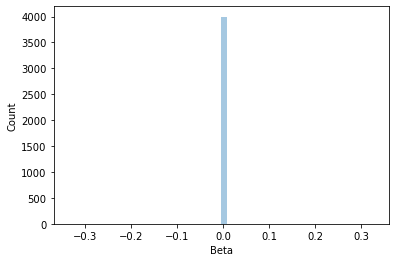

In [33]:
sns.distplot(beta_df["beta"].pct_change(), kde=False)
plt.ylabel("Count")
plt.xlabel("Beta")
plt.savefig(f"{TODAY}_{FIPS}_delta-beta-histogram.png");

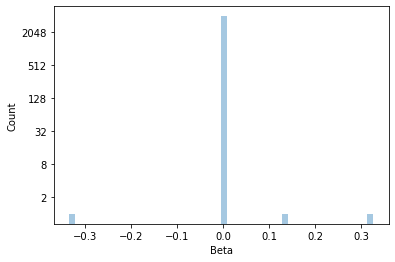

In [34]:
import matplotlib.ticker as mticker
sns.distplot(beta_df["beta"].pct_change(), kde=False)
plt.yscale("log", basey=2)
plt.ylabel("Count")
plt.xlabel("Beta")
plt.gcf().axes[0].yaxis.set_major_formatter(mticker.ScalarFormatter())
plt.savefig(f"{TODAY}_{FIPS}_log2-delta-beta-histogram.png");

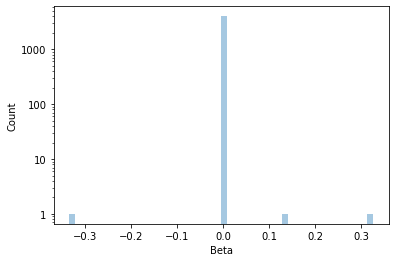

In [35]:
import matplotlib.ticker as mticker
sns.distplot(beta_df["beta"].pct_change(), kde=False)
plt.yscale("log")
plt.ylabel("Count")
plt.xlabel("Beta")
plt.gcf().axes[0].yaxis.set_major_formatter(mticker.ScalarFormatter())
plt.savefig(f"{TODAY}_{FIPS}_log10-delta-beta-histogram.png");

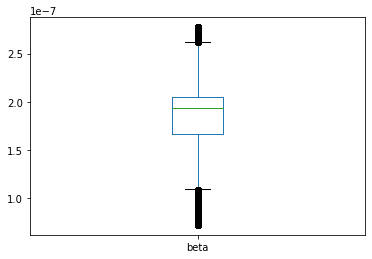

In [36]:
beta_df["beta"].plot.box();
plt.savefig(f"{TODAY}_{FIPS}_beta-boxplot.png");

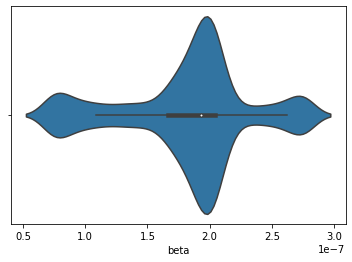

In [37]:
sns.violinplot(beta_df["beta"]);
plt.savefig(f"{TODAY}_{FIPS}_beta-violinplot.png");

# Report beta distribution stats

In [38]:
beta_df["beta"].kurtosis()

0

In [39]:
beta_df["beta"].skew()

0.0

In [40]:
beta_df["beta"].describe()

count    4.000000e+03
mean     1.819226e-07
std      5.111521e-08
min      7.189728e-08
25%      1.661456e-07
50%      1.930642e-07
75%      2.044562e-07
max      2.773755e-07
Name: beta, dtype: float64

# Test for deviation from normality

In [41]:
scipy.stats.shapiro(beta_df["beta"]).pvalue

3.3743267020941595e-42

In [42]:
scipy.stats.normaltest(beta_df["beta"]).pvalue

1.628765923124826e-31

In [43]:
scipy.stats.kstest(beta_df["beta"], 'norm').pvalue

0.0

# Save beta dataframe as a csv

In [44]:
beta_df.to_csv(OUTPUT_FILE_NAME, index=False)